# Partial Correlation and DAG

### 1. Create a graphical skeleton like the one created above using the Economic Freedom of the World Index and Real GDP.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy
from matplotlib.patches import ArrowStyle
from pgmpy.estimators import PC
import pingouin
import statsmodels.api as sm
import random

In [13]:
data = pd.read_csv("fraserDataWithRGDPPC.csv", index_col = [0,1], parse_dates = True)
years = np.array(sorted(list(set(data.index.get_level_values("Year")))))
years = pd.date_range(years[0],
                      years[-2], 
                      freq = "AS")
countries  = sorted(list(set(data.index.get_level_values("ISO_Code"))))
index_names = list(data.index.names)
multi_index = pd.MultiIndex.from_product([countries, years[:-1]],
                                         names = data.index.names)
data = data.reindex(multi_index)
data = data.dropna(axis = 0, 
                   thresh = 1).dropna(axis = 1, 
                                      thresh = 1)
data

EFW  Size of Government  \
ISO_Code Year                                       
AGO      2005-01-01  4.002282            4.652865   
         2006-01-01  4.883132            5.342913   
         2007-01-01  4.980365            5.239228   
         2008-01-01  4.980803            5.307379   
         2009-01-01  5.357889            7.104953   
...                       ...                 ...   
ZWE      2011-01-01  4.843441            6.424630   
         2012-01-01  4.971192            6.670469   
         2013-01-01  5.246723            6.325105   
         2014-01-01  5.582478            6.433165   
         2015-01-01  6.145330            6.402772   

                     Legal System & Property Rights  Sound Money  \
ISO_Code Year                                                      
AGO      2005-01-01                        3.148805     1.262168   
         2006-01-01                        3.546463     4.061198   
         2007-01-01                        3.569182     4.453327   
         2008-01-01                        3.654098     5.032836   
         2009-01-01                        3.622792     5.238259   
...                                             ...          ...   
ZWE      2011-01-01                        3.943725     4.109198   
         2012-01-01                        4.013004     5.378742   
         2013-01-01                        3.575827     6.895530   
         2014-01-01                        3.615584     7.966798   
         2015-01-01                        3.820360     8.180178   

                     Freedom to trade internationally  Regulation  \
ISO_Code Year                                                       
AGO      2005-01-01                          6.218266    4.729310   
         2006-01-01                          6.158949    5.306135   
         2007-01-01                          6.115462    5.524626   
         2008-01-01                          5.687976    5.221726   
         2009-01-01                          5.811844    5.011598   
...                                               ...         ...   
ZWE      2011-01-01                          5.366773    4.372878   
         2012-01-01                          5.132305    3.661438   
         2013-01-01                          5.589087    3.848068   
         2014-01-01                          5.909121    3.987721   
         2015-01-01                          5.679719    6.643620   

                     RGDP Per Capita  
ISO_Code Year                         
AGO      2005-01-01           5136.0  
         2006-01-01           6024.0  
         2007-01-01           7173.0  
         2008-01-01           7936.0  
         2009-01-01           7900.0  
...                              ...  
ZWE      2011-01-01           1515.0  
         2012-01-01           1604.0  
         2013-01-01           1604.0  
         2014-01-01           1594.0  
         2015-01-01           1560.0  

[2706 rows x 7 columns]

In [16]:
undirected_graph = {key:[] for key in data.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in data.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

In [34]:
p_val = 0.01
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables
                # uses them as controls statistical significance hold without them, 
                # otherwise break
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x!=y: 
                test = df.partial_corr(x=x, 
                                       y=y, 
                                       covar = None, 
                                       method = "pearson")
                if test["p-val"].values[0]>p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z!=y and z!=x]
                    check_remaining_controls(control_vars, 
                                             undirected_graph, 
                                             x, 
                                             y, 
                                             [])
    return undirected_graph

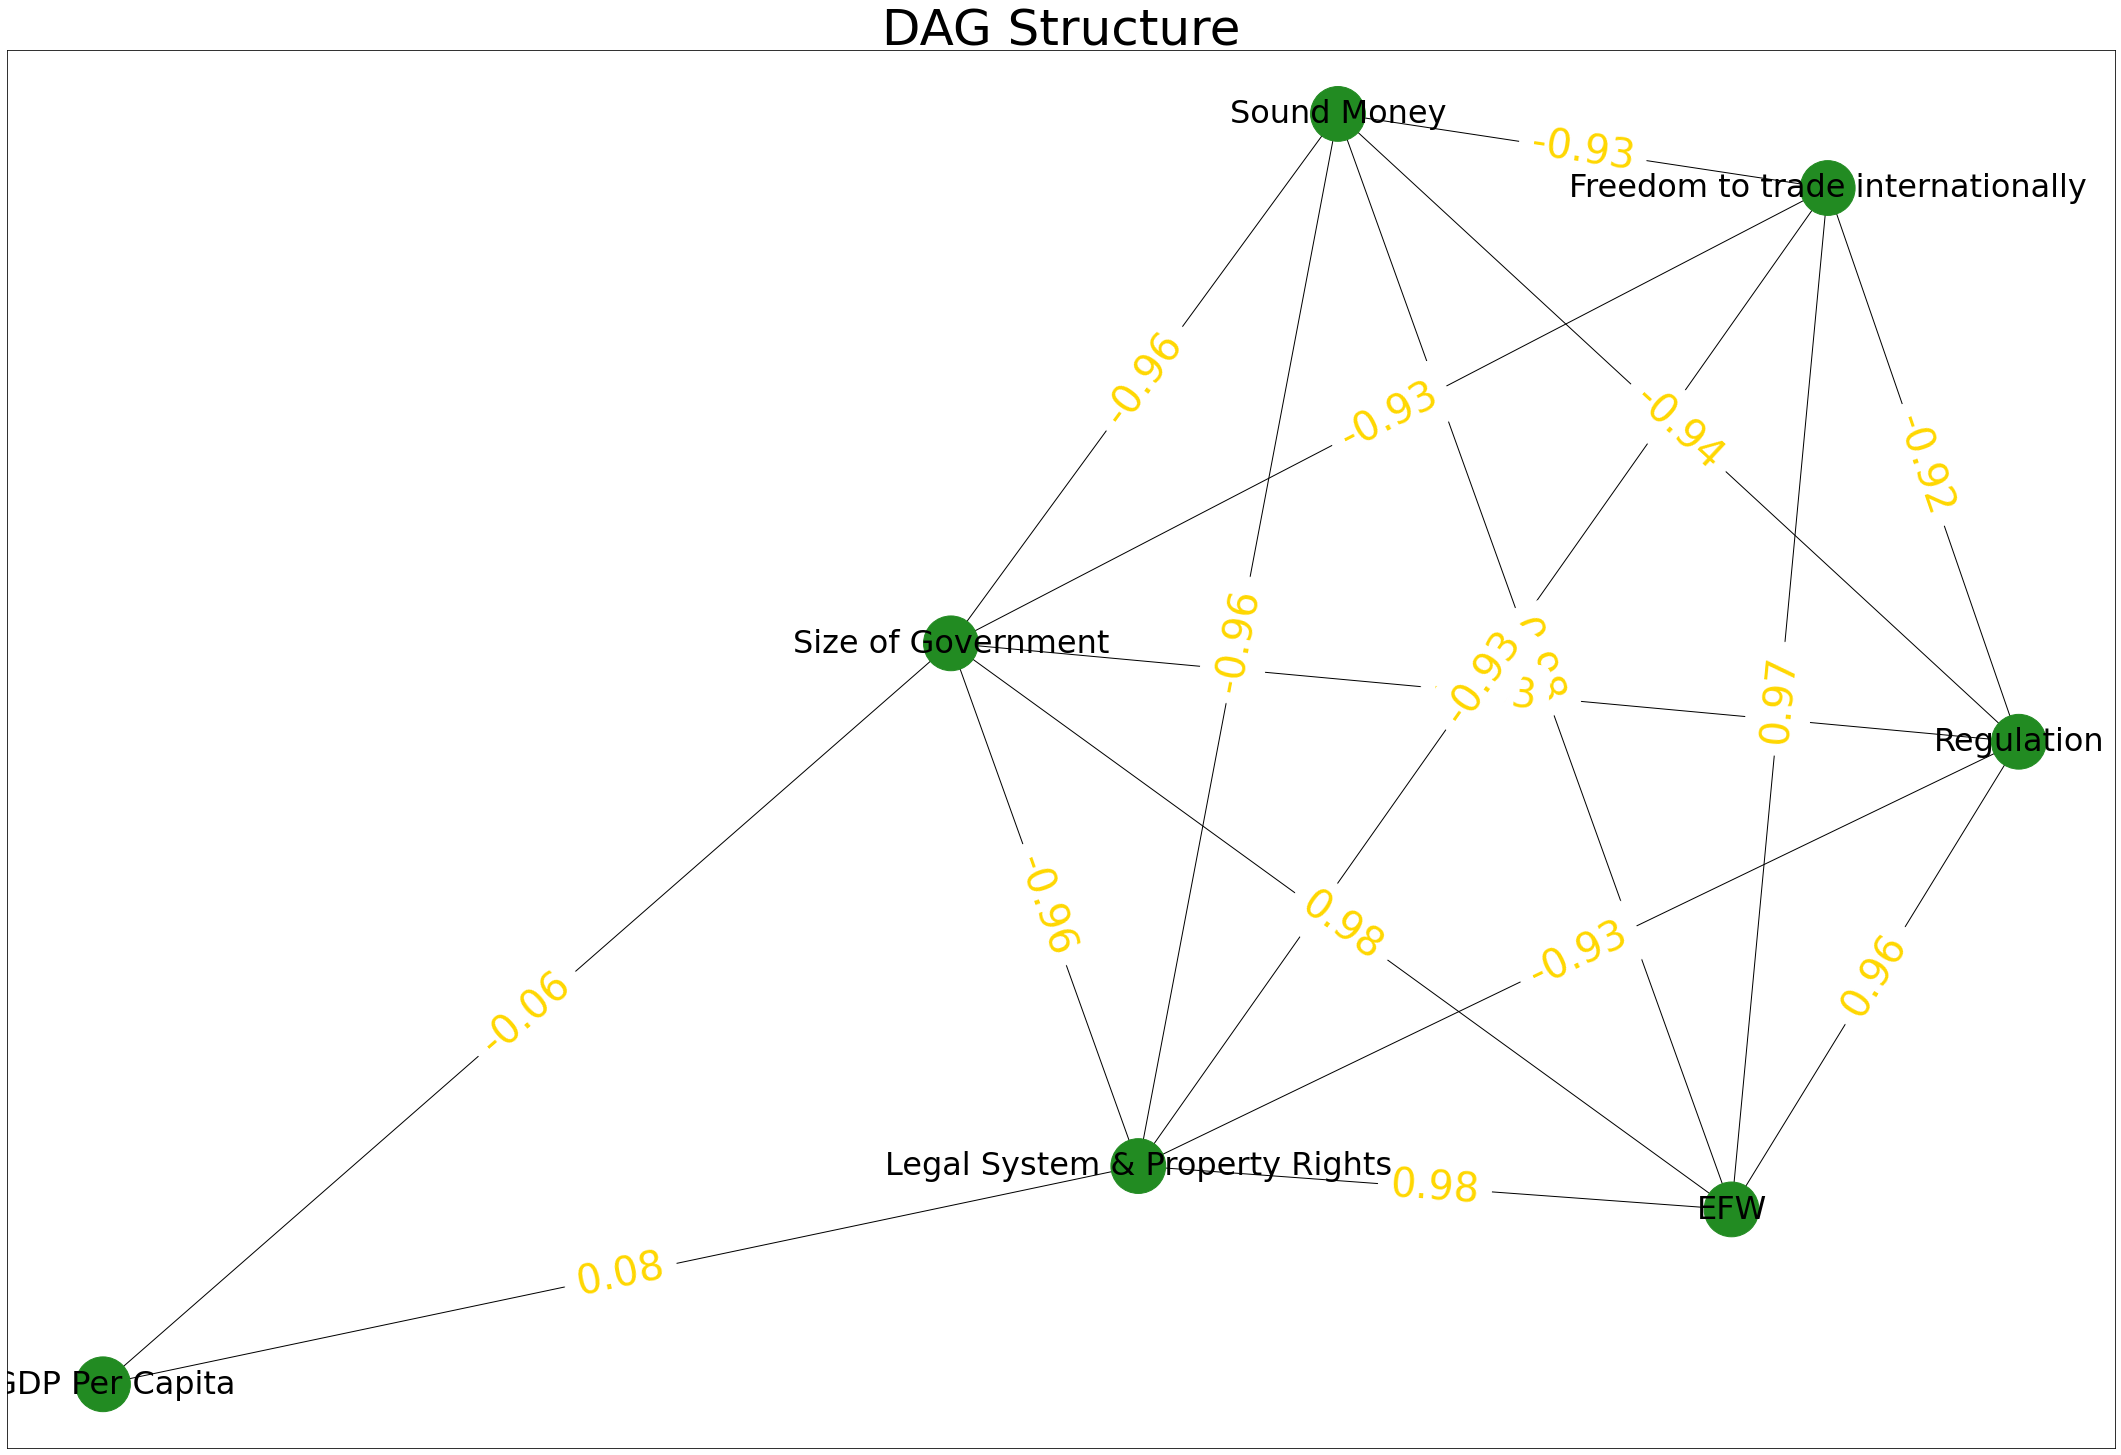

In [33]:
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key, key2)
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))

    graph.add_edges_from(edges)
    color_map = ["forestgreen" for g in graph]

    fig, ax = plt.subplots(figsize = (30,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)

    plt.title(title, fontsize = 50)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 3000,
                     with_labels=True,  
                     arrows=False,
                     font_size = 32, 
                     alpha = 1,
                     font_color = "black",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='gold',
                                 font_size=40)
    
    plt.show()
graph_DAG(undirected_graph, data)

### 2. Create a directed acyclic graph using the same data.

In [38]:
data = data.dropna()
c = PC(data)
max_cond_vars = len(data.keys())-2

model = c.estimate(return_type = "dag", 
                   variant = "parallel", 
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

('Size of Government', 'Freedom to trade internationally') []
('Freedom to trade internationally', 'EFW') []
Keep Control: EFW
('Regulation', 'Sound Money') ['EFW']
('EFW', 'Regulation') []
Keep Control: Regulation
('EFW', 'Sound Money') ['Regulation']


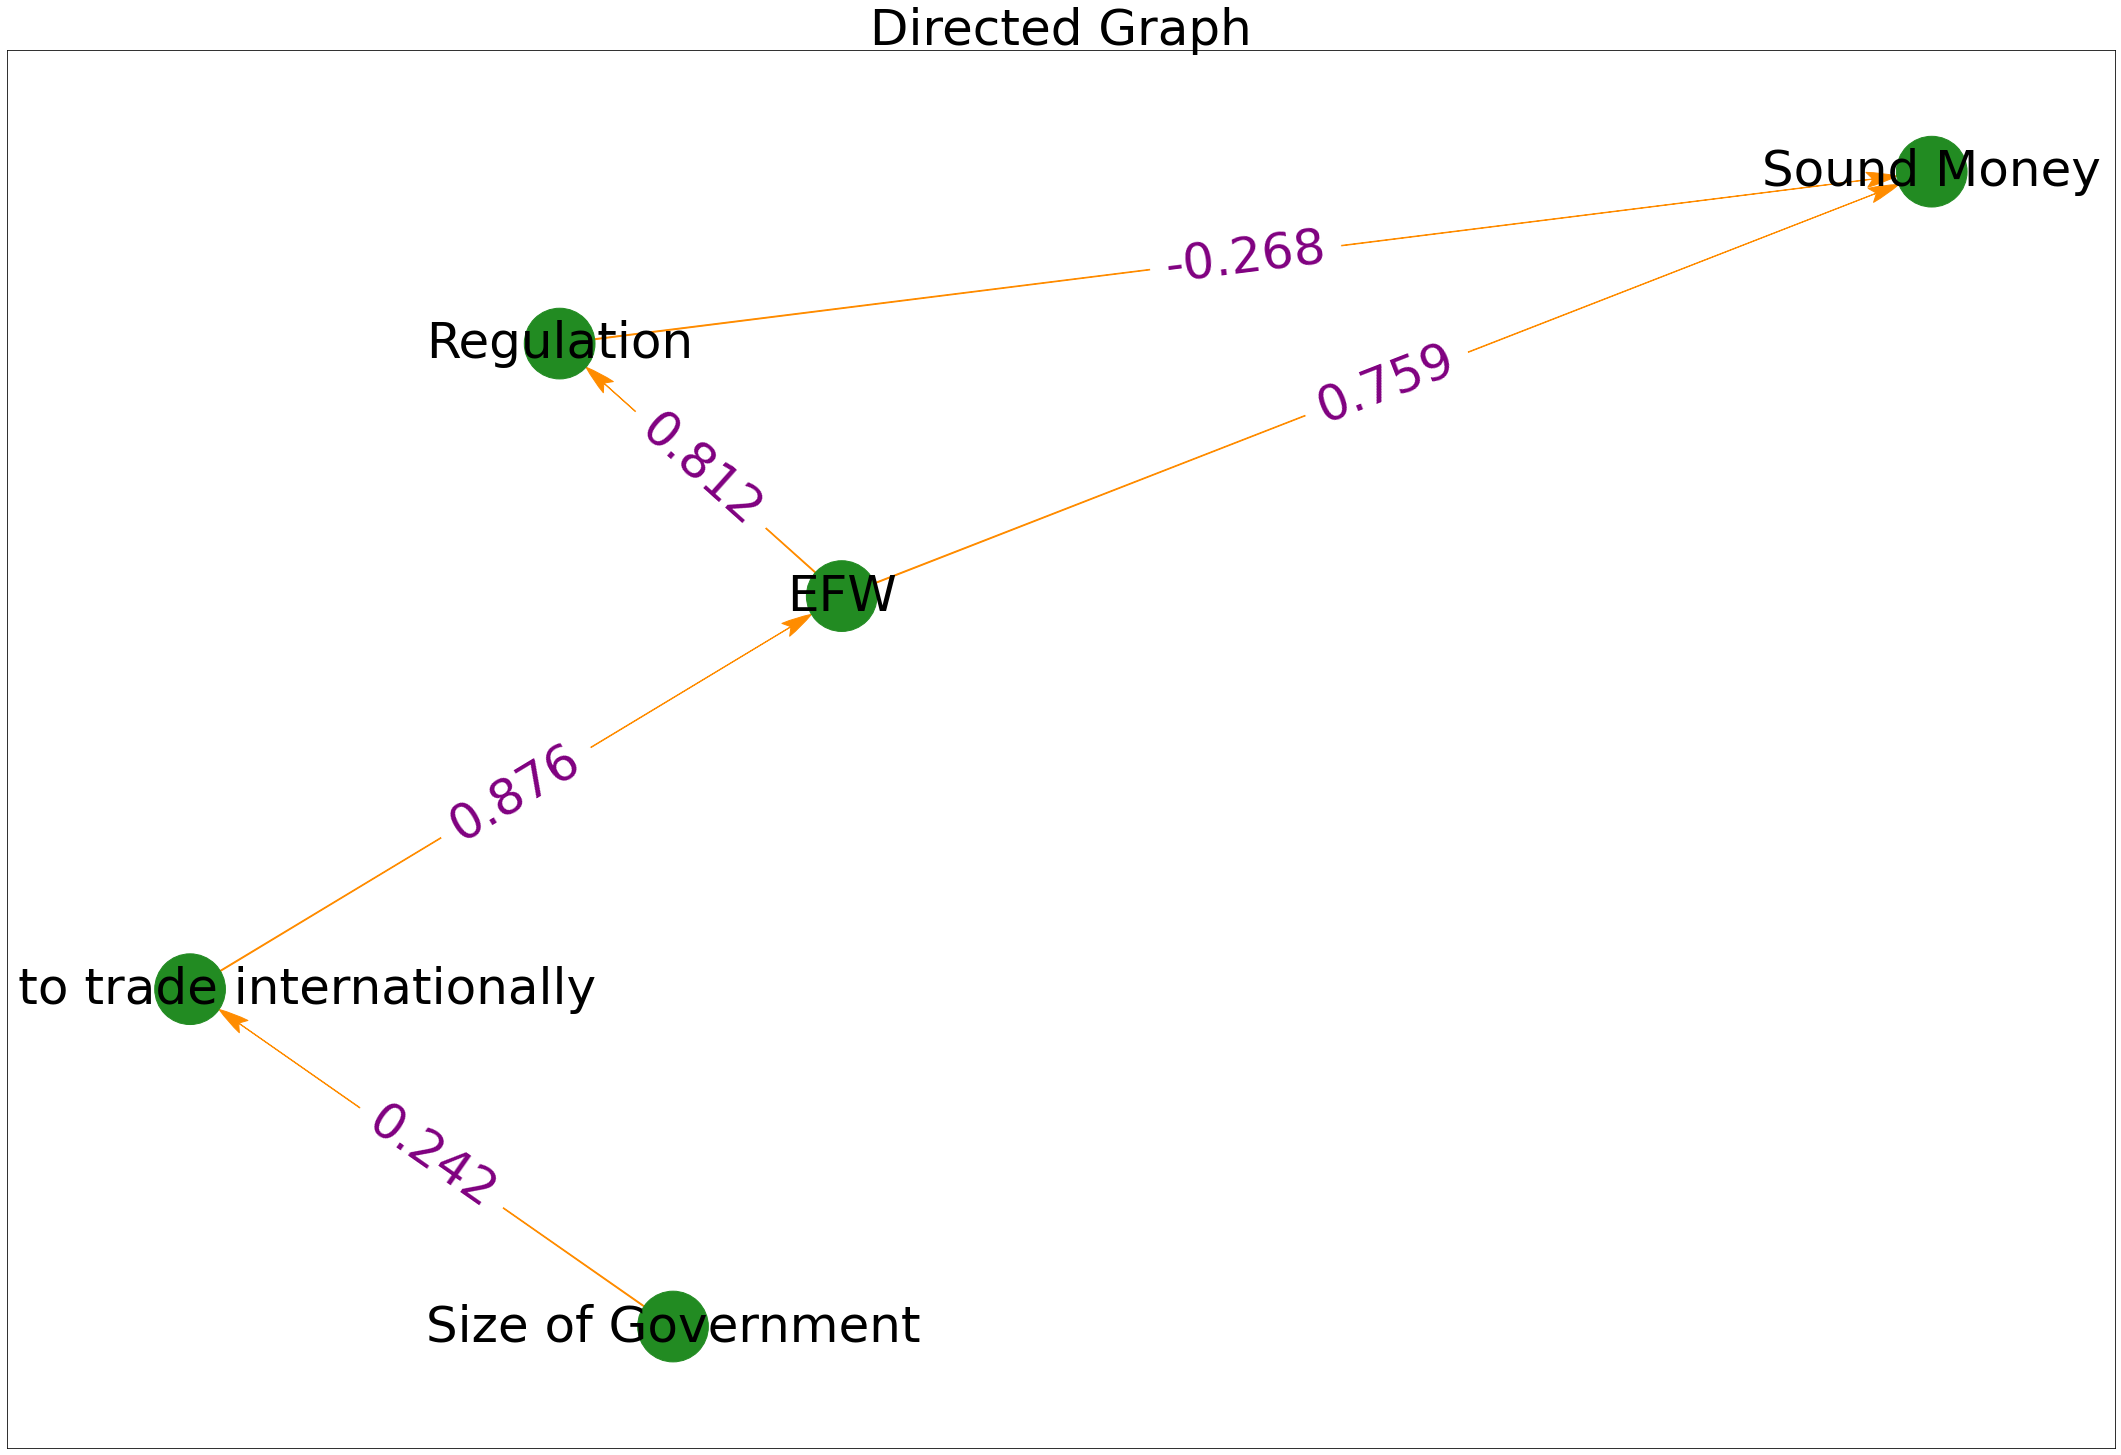

In [43]:
def graph_DAG(edges,
              df, 
              title = "Directed Graph"):
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        control = [key for key in df.keys() if key not in edge]
        control = list(set(control))
        keep_control = []
        for control in control:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0]]
            if (control, edge[1]) in control_edges:
                print("Keep Control:",  control)
                keep_control.append(control)
        print(edge, keep_control)
        pcorr = df[[edge[0], edge[1]]+keep_control].pcorr()
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],3))
        
    graph.add_edges_from(edges)
    color_map = ["forestgreen" for g in graph]
    
    fig, ax = plt.subplots(figsize = (30,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    plt.title(title, 
              fontsize = 50)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color = color_map, 
                     node_size = 5000, 
                     font_color = "black", 
                     font_size = 50, 
                     alpha = 1, 
                     width = 1, 
                     edge_color = "darkorange", 
                     arrowstyle = ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), 
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos, 
                                 edge_labels = edge_labels, 
                                 font_color = "purple", 
                                 font_size = 50)
    plt.show()
graph_DAG(edges, data)